# PLOT GENERATION
The main purpose here is to plot the reconstructions results in a paper suitable format

In [2]:
from helpers import *

In [3]:
import scipy.io
import numpy as np

def readMatToNpArray(matfilepath):
    # Load the .mat file
    mat_data = scipy.io.loadmat(matfilepath)
    # Extract the 'x' variable
    x = mat_data['x']
    # Convert to a NumPy array (if not already)
    x_arr = np.array(x)
    return x_arr

In [ ]:
# phantom l1, l2, eye l1,l2, cardiac l1,l2 
bestregsbart = [0.92367086,0.16754749,0.017433288222,0.21261123339,0.009236708572,0.3423598]
prefixes = ['phantom','eye','cardiac']
regtypes = ['l1','l2']
groundtruths = [cfl.readcfl(f'./bart_data/image_bart_{prefix}') for prefix in prefixes]

In [ ]:
import subprocess

# phantom l1, l2, eye l1,l2, cardiac l1,l2 
bestregsbart = [0.92367086,0.16754749,0.017433288222,0.21261123339,0.009236708572,0.3423598]
prefixes = ['phantom','eye','cardiac']
regtypes = ['l1','l2']
groundtruths = [cfl.readcfl(f'./bart_data/image_bart_{prefix}') for prefix in prefixes]
# RUN BART RECONS USING BEST REGVALS
cnt = 0
iterations = 250

for index, prefix in enumerate(prefixes):
    for regtype in regtypes:
        regul_param = bestregsbart[cnt]
        print(f"regularization parameter = {regul_param}")
        groundtruth = groundtruths[index]

        # Define ROI parameters based on image type
        if prefix == 'phantom':
            ellipse_params = {'center_x': 128, 'center_y': 126, 'major_axis': 89, 'minor_axis': 118, 'angle': 0}
        elif prefix == 'eye':
            ellipse_params = {'center_x': 128, 'center_y': 83, 'major_axis': 85, 'minor_axis': 113, 'angle': 0}
        elif prefix == 'cardiac':
            ellipse_params = {"center_x": 141, "center_y": 130, "major_axis": 64, "minor_axis": 45, "angle": 67}
        else:
            raise ValueError(f"Invalid prefix provided: {prefix}")

        # Construct BART command for L1 or L2 regularization
        output_path = f'./reconstructions/bart/{prefix}_{regtype}_{iterations}_iterations'
        if regtype == 'l2':
            bart_command = (
                f"./bart/bart pics -r{regul_param} -l2 -i{iterations} -t ./bart_data/traj_bart_{prefix} -p ./bart_data/weights_bart_{prefix}_scaled ./bart_data/kspace_bart_{prefix} ./bart_data/C_bart_{prefix} {output_path}"
            )
        elif regtype == 'l1':
            bart_command = (
                f"./bart/bart pics -R I:1:{regul_param} -i{iterations} -m -u {10*regul_param} -t ./bart_data/traj_bart_{prefix} -p ./bart_data/weights_bart_{prefix}_scaled ./bart_data/kspace_bart_{prefix} ./bart_data/C_bart_{prefix} {output_path}"
            )

        # Execute BART command
        try:
            subprocess.run(bart_command, shell=True, check=True)
        except subprocess.CalledProcessError as e:
            print(f"Error running BART command for {prefix} with {regtype}: {e}")
            continue  # Skip to the next iteration if BART fails

        # Read the reconstructed image
        reconstructed = cfl.readcfl(output_path)

        # Normalize the reconstruction within the specified ROI
        reconstructed = normalize_within_roi(reconstructed, groundtruth, ellipse_params)

        # Save the rescaled reconstruction in BART format
        cfl.writecfl(output_path, reconstructed)
        cnt += 1
print("BART reconstructions completed and saved successfully.")


regularization parameter = 0.92367086
[  1 256  30   8   1   1   1   1   1   1   1   1   1   1   1   1 ]
[256 256   1   8   1   1   1   1   1   1   1   1   1   1   1   1 ]
l1 regularization: 0.923671
Regularization terms: 1, Supporting variables: 0
ADMM
Total Time: 15.856608
regularization parameter = 0.16754749
[  1 256  30   8   1   1   1   1   1   1   1   1   1   1   1   1 ]
[256 256   1   8   1   1   1   1   1   1   1   1   1   1   1   1 ]
l2 regularization: 0.167547
Regularization terms: 1, Supporting variables: 0
conjugate gradients
Total Time: 9.108945
regularization parameter = 0.017433288222
[  1 256  30  42   1   1   1   1   1   1   1   1   1   1   1   1 ]
[256 256   1  42   1   1   1   1   1   1   1   1   1   1   1   1 ]
l1 regularization: 0.017433
Regularization terms: 1, Supporting variables: 0
ADMM
Total Time: 80.614053
regularization parameter = 0.21261123339
[  1 256  30  42   1   1   1   1   1   1   1   1   1   1   1   1 ]
[256 256   1  42   1   1   1   1   1   1   1  

In [9]:
# phantom l1, l2, brain l1,l2, cardiac l1,l2 cardiac2 l1,2

regtype = 'l1'
rootfilepath = './reconstructions/'
prefixes = ['phantom','eye','cardiac']
griddedrecons = [cfl.readcfl(f'./reconstructions/griddedrecons/gridded_recon_{prefix}') for prefix in prefixes]
monalisa_images_l1 = [readMatToNpArray(rootfilepath + 'monalisa/' + f'{prefix}_{regtype}.mat') for prefix in prefixes]
bart_images_l1 = [cfl.readcfl(f'./reconstructions/bart/{prefix}_{regtype}') for prefix in prefixes]

regtype = 'l2'
monalisa_images_l2 = [readMatToNpArray(rootfilepath + 'monalisa/' + f'{prefix}_{regtype}.mat') for prefix in prefixes]
bart_images_l2 = [cfl.readcfl(f'./reconstructions/bart/{prefix}_{regtype}') for prefix in prefixes]

groudtruths = [cfl.readcfl(f'./bart_data/image_bart_{prefix}') for prefix in prefixes]

In [12]:
prefix = 'eye'
regtype = 'l2'
rootfilepath = '/Users/mauroleidi/Desktop/comparisonMonalisaBartNew/comparisonMonalisaBart/reconstructions/'

filename = f'monalisa/{prefix}_{regtype}.mat'

pathtofile = rootfilepath + filename
monalisabrain = readMatToNpArray(pathtofile)

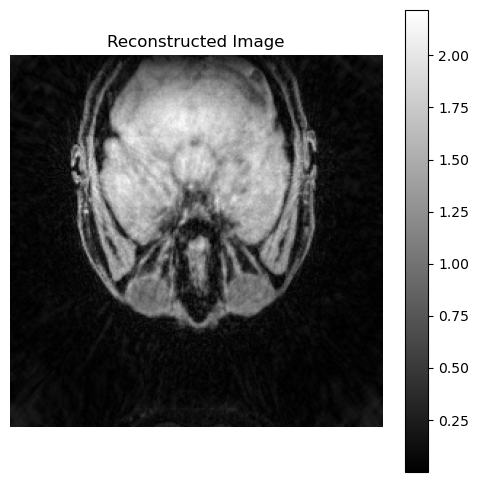

In [13]:

# Display the image
plt.figure(figsize=(6,6))
plt.imshow(np.abs(abs(monalisabrain)), cmap='gray')  # Use abs() in case of complex values
plt.colorbar()  # Optional: adds a color scale
plt.title('Reconstructed Image')
plt.axis('off')  # Hide axes
plt.show()

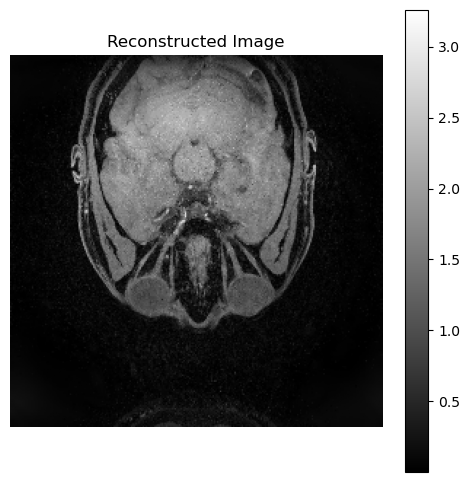

In [14]:
# Load the ground truth image: need to adjust the naming convention
prefix = 'eye'
groundtruth = cfl.readcfl(f'./bart_data/image_bart_{prefix}')
# Display the image
plt.figure(figsize=(6,6))
plt.imshow(np.abs(abs(groundtruth)), cmap='gray')  # Use abs() in case of complex values
plt.colorbar()  # Optional: adds a color scale
plt.title('Reconstructed Image')
plt.axis('off')  # Hide axes
plt.show()

We should display the images as a grid, and at the same time compute the SSIM and L2-dist for both the bart and monalisa recons for all the 4 prefixes.

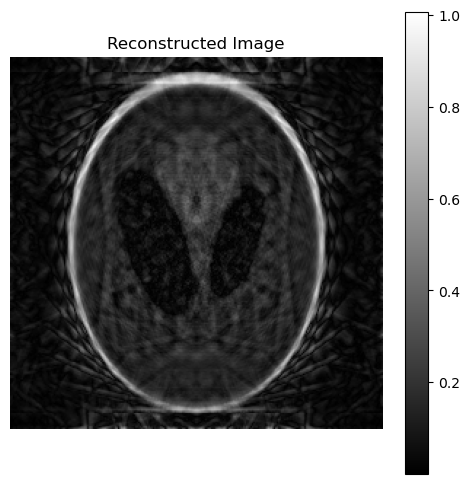

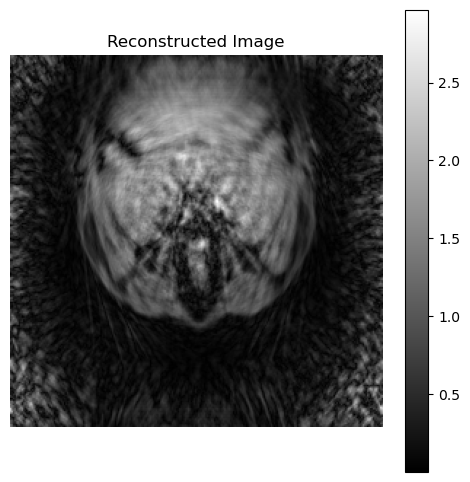

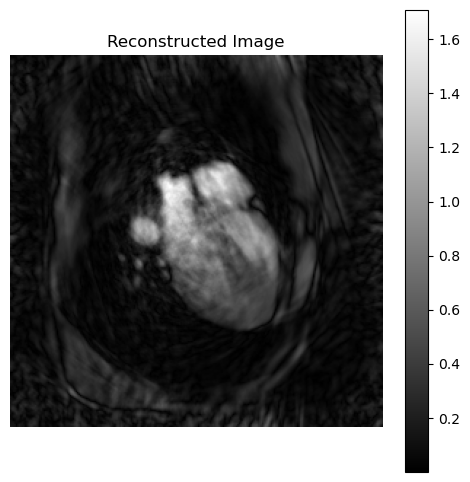

In [15]:
for recon in griddedrecons:
    # Display the image
    plt.figure(figsize=(6,6))
    plt.imshow(np.abs(abs(recon)), cmap='gray')  # Use abs() in case of complex values
    plt.colorbar()  # Optional: adds a color scale
    plt.title('Reconstructed Image')
    plt.axis('off')  # Hide axes
    plt.show()

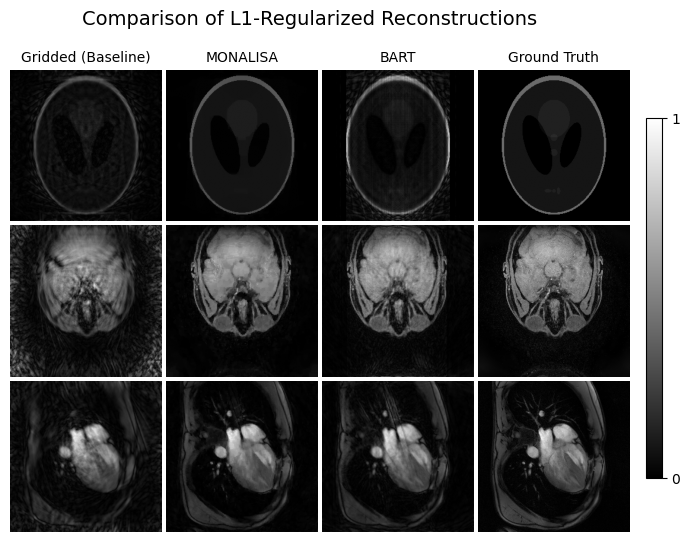

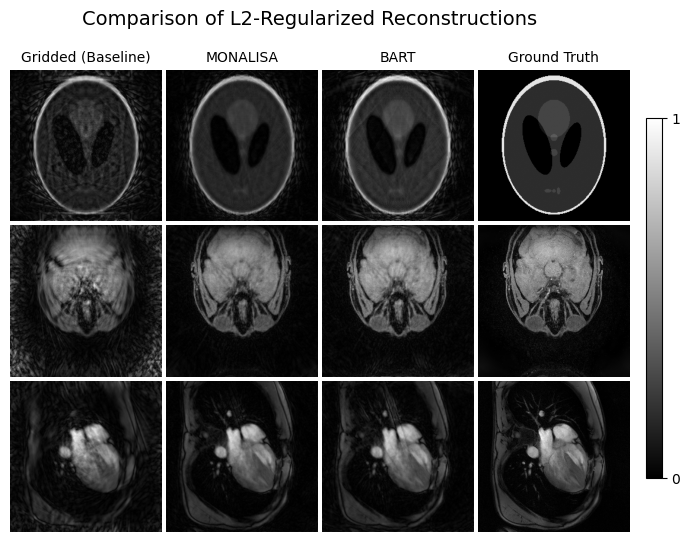


=== SSIM Scores ===
L1 Regularization (MONALISA): [np.float64(0.7618067523769169), np.float64(0.7260867793283462), np.float64(0.8200662940387576)]
L1 Regularization (BART): [np.float64(0.5152377725943824), np.float64(0.7172135498992502), np.float64(0.7458263073590421)]
L2 Regularization (MONALISA): [np.float64(0.44534846816223395), np.float64(0.7238887920173258), np.float64(0.81575456378901)]
L2 Regularization (BART): [np.float64(0.375027827833588), np.float64(0.6720453678065464), np.float64(0.727489755870695)]

=== L2 Distances ===
L1 Regularization (MONALISA): [np.float32(14.114955), np.float32(36.57865), np.float32(14.701275)]
L1 Regularization (BART): [np.float32(35.592678), np.float32(37.89747), np.float32(20.586601)]
L2 Regularization (MONALISA): [np.float32(26.651026), np.float32(42.075104), np.float32(15.651385)]
L2 Regularization (BART): [np.float32(26.384642), np.float32(39.61134), np.float32(20.385395)]


In [25]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from skimage.metrics import structural_similarity as ssim
from scipy.io import loadmat
from scipy.linalg import norm

# Function to read .mat files into numpy arrays
def readMatToNpArray(filepath):
    return np.array(loadmat(filepath)['x'])  # Adjust the key if needed

# Filepath settings
prefixes = ['phantom','eye','cardiac']
rootfilepath = './reconstructions/'

# Load Images
griddedrecons = [abs(cfl.readcfl(f'./reconstructions/griddedrecons/gridded_recon_{prefix}')) for prefix in prefixes]
groundtruths = [abs(cfl.readcfl(f'./bart_data/image_bart_{prefix}')) for prefix in prefixes]

# Load L1 images
regtype = 'l1'
monalisa_images_l1 = [readMatToNpArray(rootfilepath + 'monalisa/' + f'{prefix}_{regtype}.mat') for prefix in prefixes]
bart_images_l1 = [cfl.readcfl(f'./reconstructions/bart/{prefix}_{regtype}') for prefix in prefixes]
# Load L2 images
regtype = 'l2'
monalisa_images_l2 = [readMatToNpArray(rootfilepath + 'monalisa/' + f'{prefix}_{regtype}.mat') for prefix in prefixes]
bart_images_l2 = [cfl.readcfl(f'./reconstructions/bart/{prefix}_{regtype}') for prefix in prefixes]

# SSIM and L2 Distance Calculation
def compute_metrics(recon_images, groundtruths):
    ssim_scores = []
    l2_distances = []

    for recon, gt in zip(recon_images, groundtruths):
        # Compute SSIM (convert to magnitude before computing)
        ssim_value = ssim(abs(recon), abs(gt), data_range=gt.max() - gt.min())
        ssim_scores.append(ssim_value)

        # Compute L2 distance
        l2_distance = norm(abs(recon) - abs(gt))
        l2_distances.append(l2_distance)

    return ssim_scores, l2_distances

# Compute metrics for each reconstruction type
ssim_l1, l2_l1 = compute_metrics(monalisa_images_l1, groundtruths)
ssim_l2, l2_l2 = compute_metrics(monalisa_images_l2, groundtruths)
ssim_bart_l1, l2_bart_l1 = compute_metrics(bart_images_l1, groundtruths)
ssim_bart_l2, l2_bart_l2 = compute_metrics(bart_images_l2, groundtruths)

# Organize data for plotting
titles = ['Gridded (Baseline)', 'MONALISA', 'BART', 'Ground Truth']
row_titles = ['Phantom', 'Eye', 'Cardiac']

def plot_reconstructions(images, title):
    fig = plt.figure(figsize=(8, 6))
    gs = GridSpec(3, 4, figure=fig, hspace=0.025, wspace=0.025)

    for i, row in enumerate(images):
        row_min = min(abs(image).min() for image in row)
        row_max = max(abs(image).max() for image in row)

        for j, image in enumerate(row):
            ax = fig.add_subplot(gs[i, j])
            im = ax.imshow(abs(image), cmap='gray', vmin=row_min, vmax=row_max)
            ax.axis('off')

            if i == 0:
                ax.set_title(titles[j], fontsize=10)
            if j == 0:
                ax.set_ylabel(row_titles[i], fontsize=10, rotation=90, labelpad=10)

    # Add a single colorbar from 0 to 1 (black to white)
    cbar_ax = fig.add_axes([0.92, 0.2, 0.02, 0.6])  # Position of the colorbar
    norm = plt.Normalize(vmin=0, vmax=1)  # Fixed 0-1 scale
    sm = plt.cm.ScalarMappable(cmap="gray", norm=norm)
    sm.set_array([])  # Dummy array for colorbar
    cbar = fig.colorbar(sm, cax=cbar_ax)

    # Set custom ticks and labels
    cbar.set_ticks([0, 1])
    cbar.set_ticklabels(["0", "1"])

    plt.suptitle(title, fontsize=14)
    plt.show()

# Plot L1 reconstructions
images_l1 = list(zip(griddedrecons, monalisa_images_l1, bart_images_l1, groundtruths))
plot_reconstructions(images_l1, 'Comparison of L1-Regularized Reconstructions')

# Plot L2 reconstructions
images_l2 = list(zip(griddedrecons, monalisa_images_l2, bart_images_l2, groundtruths))
plot_reconstructions(images_l2, 'Comparison of L2-Regularized Reconstructions')

# Print SSIM and L2 Distances
print("\n=== SSIM Scores ===")
print("L1 Regularization (MONALISA):", ssim_l1)
print("L1 Regularization (BART):", ssim_bart_l1)
print("L2 Regularization (MONALISA):", ssim_l2)
print("L2 Regularization (BART):", ssim_bart_l2)

print("\n=== L2 Distances ===")
print("L1 Regularization (MONALISA):", l2_l1)
print("L1 Regularization (BART):", l2_bart_l1)
print("L2 Regularization (MONALISA):", l2_l2)
print("L2 Regularization (BART):", l2_bart_l2)


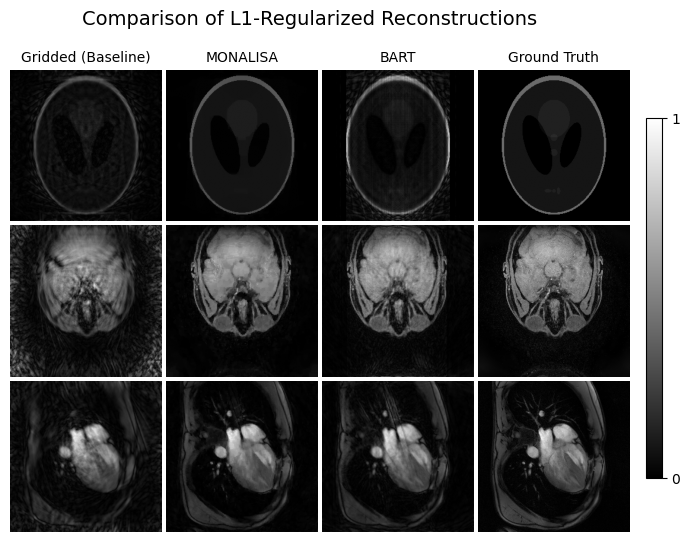

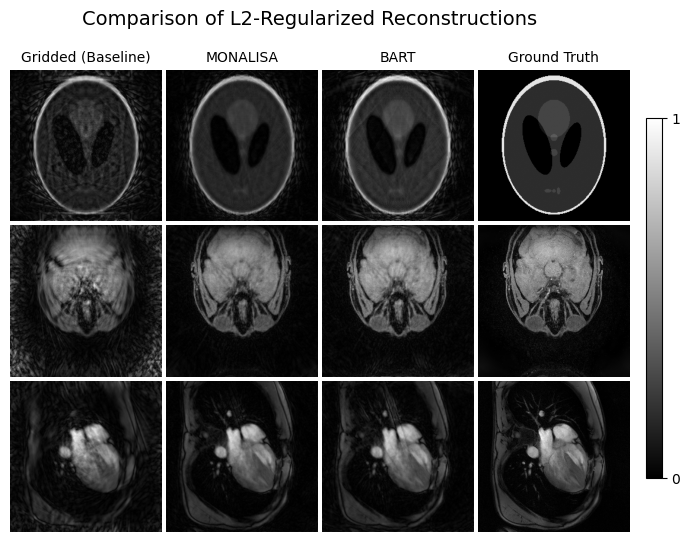


=== SSIM Scores ===
Gridded Reconstructions: [np.float64(0.24916175977705057), np.float64(0.32396044323731366), np.float64(0.4881618366807244)]
L1 Regularization (MONALISA): [np.float64(0.7618067523769169), np.float64(0.7260867793283462), np.float64(0.8200662940387576)]
L1 Regularization (BART): [np.float64(0.5152377725943824), np.float64(0.7172135498992502), np.float64(0.7458263073590421)]
L2 Regularization (MONALISA): [np.float64(0.44534846816223395), np.float64(0.7238887920173258), np.float64(0.81575456378901)]
L2 Regularization (BART): [np.float64(0.375027827833588), np.float64(0.6720453678065464), np.float64(0.727489755870695)]

=== L2 Distances ===
Gridded Reconstructions: [np.float32(31.676746), np.float32(94.86667), np.float32(31.376436)]
L1 Regularization (MONALISA): [np.float32(14.114955), np.float32(36.57865), np.float32(14.701275)]
L1 Regularization (BART): [np.float32(35.592678), np.float32(37.89747), np.float32(20.586601)]
L2 Regularization (MONALISA): [np.float32(26.651

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from skimage.metrics import structural_similarity as ssim
from scipy.io import loadmat
from scipy.linalg import norm

# Function to read .mat files into numpy arrays
def readMatToNpArray(filepath):
    return np.array(loadmat(filepath)['x'])  # Adjust the key if needed

# Filepath settings
prefixes = ['phantom','eye','cardiac']
rootfilepath = './reconstructions/'

# Load Images
griddedrecons = [abs(cfl.readcfl(f'./reconstructions/griddedrecons/gridded_recon_{prefix}')) for prefix in prefixes]
groundtruths = [abs(cfl.readcfl(f'./bart_data/image_bart_{prefix}')) for prefix in prefixes]

# Load L1 images
regtype = 'l1'
monalisa_images_l1 = [readMatToNpArray(rootfilepath + 'monalisa/' + f'{prefix}_{regtype}.mat') for prefix in prefixes]
bart_images_l1 = [cfl.readcfl(f'./reconstructions/bart/{prefix}_{regtype}') for prefix in prefixes]
# Load L2 images
regtype = 'l2'
monalisa_images_l2 = [readMatToNpArray(rootfilepath + 'monalisa/' + f'{prefix}_{regtype}.mat') for prefix in prefixes]
bart_images_l2 = [cfl.readcfl(f'./reconstructions/bart/{prefix}_{regtype}') for prefix in prefixes]

# SSIM and L2 Distance Calculation
def compute_metrics(recon_images, groundtruths):
    ssim_scores = []
    l2_distances = []

    for recon, gt in zip(recon_images, groundtruths):
        # Compute SSIM (convert to magnitude before computing)
        ssim_value = ssim(abs(recon), abs(gt), data_range=gt.max() - gt.min())
        ssim_scores.append(ssim_value)

        # Compute L2 distance
        l2_distance = norm(abs(recon) - abs(gt))
        l2_distances.append(l2_distance)

    return ssim_scores, l2_distances

# Compute metrics for each reconstruction type
ssim_gridded, l2_gridded = compute_metrics(griddedrecons, groundtruths)
ssim_l1, l2_l1 = compute_metrics(monalisa_images_l1, groundtruths)
ssim_l2, l2_l2 = compute_metrics(monalisa_images_l2, groundtruths)
ssim_bart_l1, l2_bart_l1 = compute_metrics(bart_images_l1, groundtruths)
ssim_bart_l2, l2_bart_l2 = compute_metrics(bart_images_l2, groundtruths)

# Organize data for plotting
titles = ['Gridded (Baseline)', 'MONALISA', 'BART', 'Ground Truth']
row_titles = ['Phantom', 'Brain', 'Cardiac (Close)', 'Cardiac (Far)','Cardiac (New)']

def plot_reconstructions(images, title):
    fig = plt.figure(figsize=(8, 6))
    gs = GridSpec(3, 4, figure=fig, hspace=0.025, wspace=0.025)

    for i, row in enumerate(images):
        row_min = min(abs(image).min() for image in row)
        row_max = max(abs(image).max() for image in row)

        for j, image in enumerate(row):
            ax = fig.add_subplot(gs[i, j])
            im = ax.imshow(abs(image), cmap='gray', vmin=row_min, vmax=row_max)
            ax.axis('off')

            if i == 0:
                ax.set_title(titles[j], fontsize=10)
            if j == 0:
                ax.set_ylabel(row_titles[i], fontsize=10, rotation=90, labelpad=10)

    # Add a single colorbar from 0 to 1 (black to white)
    cbar_ax = fig.add_axes([0.92, 0.2, 0.02, 0.6])  # Position of the colorbar
    norm = plt.Normalize(vmin=0, vmax=1)  # Fixed 0-1 scale
    sm = plt.cm.ScalarMappable(cmap="gray", norm=norm)
    sm.set_array([])  # Dummy array for colorbar
    cbar = fig.colorbar(sm, cax=cbar_ax)

    # Set custom ticks and labels
    cbar.set_ticks([0, 1])
    cbar.set_ticklabels(["0", "1"])

    plt.suptitle(title, fontsize=14)
    plt.show()

# Plot L1 reconstructions
images_l1 = list(zip(griddedrecons, monalisa_images_l1, bart_images_l1, groundtruths))
plot_reconstructions(images_l1, 'Comparison of L1-Regularized Reconstructions')

# Plot L2 reconstructions
images_l2 = list(zip(griddedrecons, monalisa_images_l2, bart_images_l2, groundtruths))
plot_reconstructions(images_l2, 'Comparison of L2-Regularized Reconstructions')

# Print SSIM and L2 Distances
print("\n=== SSIM Scores ===")
print("Gridded Reconstructions:", ssim_gridded)
print("L1 Regularization (MONALISA):", ssim_l1)
print("L1 Regularization (BART):", ssim_bart_l1)
print("L2 Regularization (MONALISA):", ssim_l2)
print("L2 Regularization (BART):", ssim_bart_l2)

print("\n=== L2 Distances ===")
print("Gridded Reconstructions:", l2_gridded)
print("L1 Regularization (MONALISA):", l2_l1)
print("L1 Regularization (BART):", l2_bart_l1)
print("L2 Regularization (MONALISA):", l2_l2)
print("L2 Regularization (BART):", l2_bart_l2)


0.52923162
3.5999999999999996
1.0717641


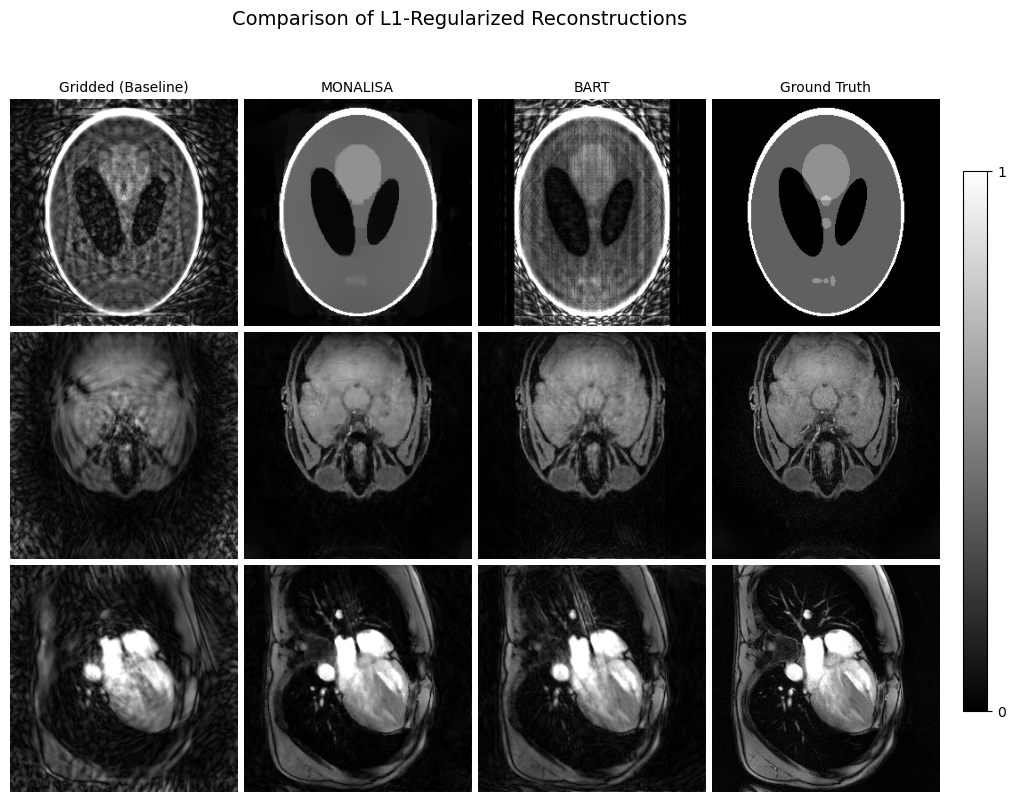

0.52923162
3.5999999999999996
1.0717641


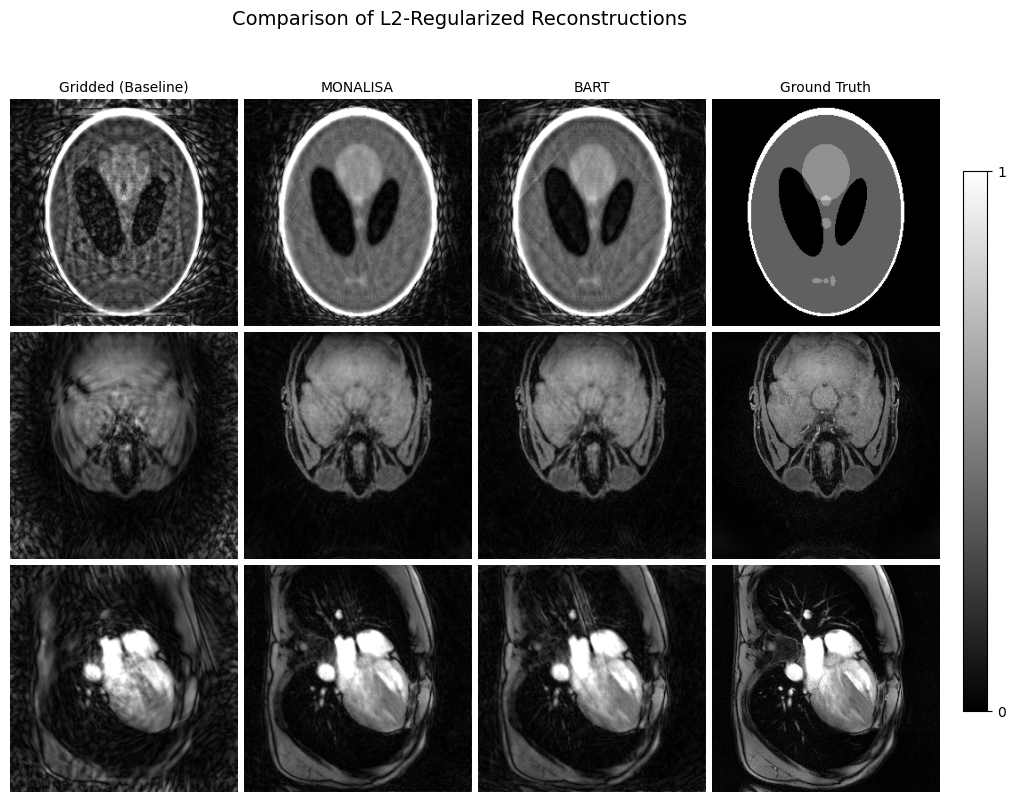


=== SSIM Scores ===
Gridded Reconstructions: [np.float64(0.24916175977705057), np.float64(0.32396044323731366), np.float64(0.4881618366807244)]
L1 Regularization (MONALISA): [np.float64(0.751605840396584), np.float64(0.7333491327647269), np.float64(0.8192665249090045)]
L1 Regularization (BART): [np.float64(0.5152377725943824), np.float64(0.7172135498992502), np.float64(0.7458263073590421)]
L2 Regularization (MONALISA): [np.float64(0.4181953761907641), np.float64(0.7258333530287892), np.float64(0.8164605497575774)]
L2 Regularization (BART): [np.float64(0.375027827833588), np.float64(0.6720453678065464), np.float64(0.727489755870695)]

=== L2 Distances ===
Gridded Reconstructions: [np.float32(31.676746), np.float32(94.86667), np.float32(31.376436)]
L1 Regularization (MONALISA): [np.float32(11.454739), np.float32(35.56387), np.float32(14.823955)]
L1 Regularization (BART): [np.float32(35.592678), np.float32(37.89747), np.float32(20.586601)]
L2 Regularization (MONALISA): [np.float32(24.242

In [ ]:
# HERE WE JUST IMPROVE THE PAGINATION AND CONTRAST FOR PRESENTING THE IMAGES

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from skimage.metrics import structural_similarity as ssim
from scipy.io import loadmat
from scipy.linalg import norm

# Function to read .mat files into numpy arrays
def readMatToNpArray(filepath):
    return np.array(loadmat(filepath)['x'])  # Adjust the key if needed

# Filepath settings
prefixes = ['phantom','eye','cardiac']
rootfilepath = './reconstructions/'

# Load Images
griddedrecons = [abs(cfl.readcfl(f'./reconstructions/griddedrecons/gridded_recon_{prefix}')) for prefix in prefixes]
groundtruths = [abs(cfl.readcfl(f'./bart_data/image_bart_{prefix}')) for prefix in prefixes]

# Load L1 images
regtype = 'l1'
monalisa_images_l1 = [readMatToNpArray(rootfilepath + 'monalisa/' + f'{prefix}_{regtype}.mat') for prefix in prefixes]
bart_images_l1 = [cfl.readcfl(f'./reconstructions/bart/{prefix}_{regtype}') for prefix in prefixes]
# Load L2 images
regtype = 'l2'
monalisa_images_l2 = [readMatToNpArray(rootfilepath + 'monalisa/' + f'{prefix}_{regtype}.mat') for prefix in prefixes]
bart_images_l2 = [cfl.readcfl(f'./reconstructions/bart/{prefix}_{regtype}') for prefix in prefixes]


# SSIM and L2 Distance Calculation
def compute_metrics(recon_images, groundtruths):
    ssim_scores = []
    l2_distances = []

    for recon, gt in zip(recon_images, groundtruths):
        # Compute SSIM (convert to magnitude before computing)
        ssim_value = ssim(abs(recon), abs(gt), data_range=gt.max() - gt.min())
        ssim_scores.append(ssim_value)

        # Compute L2 distance
        l2_distance = norm(abs(recon) - abs(gt))
        l2_distances.append(l2_distance)

    return ssim_scores, l2_distances

# Compute metrics for each reconstruction type
ssim_gridded, l2_gridded = compute_metrics(griddedrecons, groundtruths)
ssim_l1, l2_l1 = compute_metrics(monalisa_images_l1, groundtruths)
ssim_l2, l2_l2 = compute_metrics(monalisa_images_l2, groundtruths)
ssim_bart_l1, l2_bart_l1 = compute_metrics(bart_images_l1, groundtruths)
ssim_bart_l2, l2_bart_l2 = compute_metrics(bart_images_l2, groundtruths)

# Organize data for plotting
titles = ['Gridded (Baseline)', 'MONALISA', 'BART', 'Ground Truth']
row_titles = ['Phantom', 'Brain', 'Cardiac']
factor = 0.3
row_maxs = [1.7641054*0.3,6*0.6,1.7862735*0.6]

def plot_reconstructions(images, title):
    fig = plt.figure(figsize=(3*(len(prefixes)+ 1), 3*(len(titles) -1)))
    gs = GridSpec(len(prefixes), 4, figure=fig, hspace=0.025, wspace=0.025)

    for i, row in enumerate(images):
        row_min = min(abs(image).min() for image in row)
        row_max = max(abs(image).max() for image in row)
        row_max = row_maxs[i]
        print(row_max)
        for j, image in enumerate(row):
            ax = fig.add_subplot(gs[i, j])
            im = ax.imshow(abs(image), cmap='gray', vmin=row_min, vmax=row_max)
            ax.axis('off')

            if i == 0:
                ax.set_title(titles[j], fontsize=10)
            if j == 0:
                ax.set_ylabel(row_titles[i], fontsize=10, rotation=90, labelpad=10)

    # Add a single colorbar from 0 to 1 (black to white)
    cbar_ax = fig.add_axes([0.92, 0.2, 0.02, 0.6])  # Position of the colorbar
    norm = plt.Normalize(vmin=0, vmax=1)  # Fixed 0-1 scale
    sm = plt.cm.ScalarMappable(cmap="gray", norm=norm)
    sm.set_array([])  # Dummy array for colorbar
    cbar = fig.colorbar(sm, cax=cbar_ax)

    # Set custom ticks and labels
    cbar.set_ticks([0, 1])
    cbar.set_ticklabels(["0", "1"])

    plt.suptitle(title, fontsize=14)
    plt.show()

# Plot L1 reconstructions
images_l1 = list(zip(griddedrecons, monalisa_images_l1, bart_images_l1, groundtruths))
plot_reconstructions(images_l1, 'Comparison of L1-Regularized Reconstructions')

# Plot L2 reconstructions
images_l2 = list(zip(griddedrecons, monalisa_images_l2, bart_images_l2, groundtruths))
plot_reconstructions(images_l2, 'Comparison of L2-Regularized Reconstructions')

# Print SSIM and L2 Distances
print("\n=== SSIM Scores ===")
print("Gridded Reconstructions:", ssim_gridded)
print("L1 Regularization (MONALISA):", ssim_l1)
print("L1 Regularization (BART):", ssim_bart_l1)
print("L2 Regularization (MONALISA):", ssim_l2)
print("L2 Regularization (BART):", ssim_bart_l2)

print("\n=== L2 Distances ===")
print("Gridded Reconstructions:", l2_gridded)
print("L1 Regularization (MONALISA):", l2_l1)
print("L1 Regularization (BART):", l2_bart_l1)
print("L2 Regularization (MONALISA):", l2_l2)
print("L2 Regularization (BART):", l2_bart_l2)


# COMPARE WITH BART USING 250 ITERATIONS FOR SUPPLEMENTARY MATERIAL

0.52923162
3.5999999999999996
1.0717641


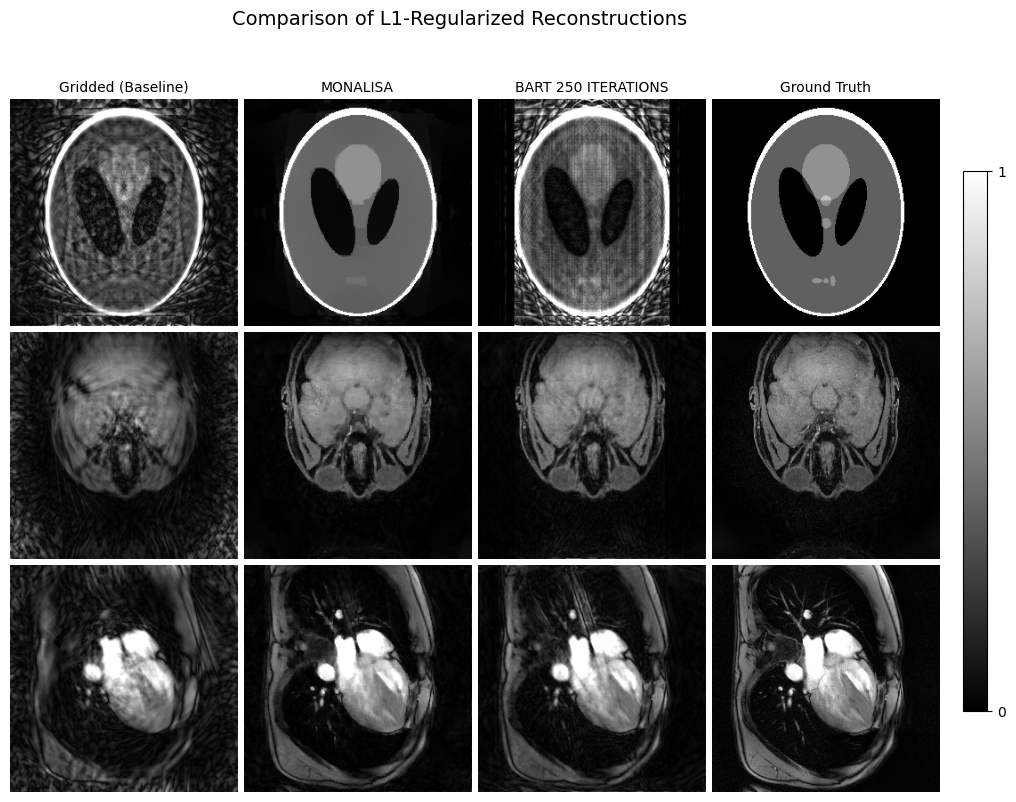

0.52923162
3.5999999999999996
1.0717641


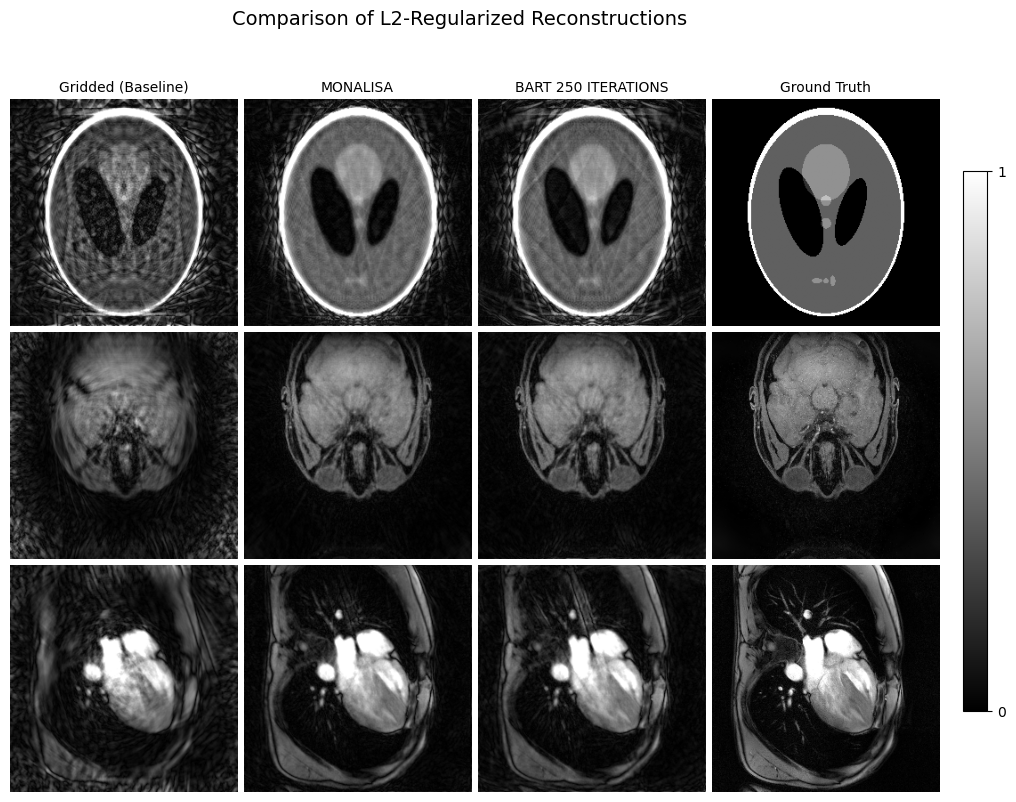


=== SSIM Scores ===
Gridded Reconstructions: [np.float64(0.24916175977705057), np.float64(0.32396044323731366), np.float64(0.4881618366807244)]
L1 Regularization (MONALISA): [np.float64(0.751605840396584), np.float64(0.7333491327647269), np.float64(0.8192665249090045)]
L1 Regularization (BART): [np.float64(0.5149841171702576), np.float64(0.7172130777627714), np.float64(0.745283862977467)]
L2 Regularization (MONALISA): [np.float64(0.4181953761907641), np.float64(0.7258333530287892), np.float64(0.8164605497575774)]
L2 Regularization (BART): [np.float64(0.375027827833588), np.float64(0.6720453665392324), np.float64(0.7274898275798718)]

=== L2 Distances ===
Gridded Reconstructions: [np.float32(31.676746), np.float32(94.86667), np.float32(31.376436)]
L1 Regularization (MONALISA): [np.float32(11.454739), np.float32(35.56387), np.float32(14.823955)]
L1 Regularization (BART): [np.float32(36.159748), np.float32(37.897823), np.float32(20.64573)]
L2 Regularization (MONALISA): [np.float32(24.242

In [54]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from skimage.metrics import structural_similarity as ssim
from scipy.io import loadmat
from scipy.linalg import norm

# Function to read .mat files into numpy arrays
def readMatToNpArray(filepath):
    return np.array(loadmat(filepath)['x'])  # Adjust the key if needed

# Filepath settings
prefixes = ['phantom','eye','cardiac']
rootfilepath = './reconstructions/'

# Load Images
griddedrecons = [abs(cfl.readcfl(f'./reconstructions/griddedrecons/gridded_recon_{prefix}')) for prefix in prefixes]
groundtruths = [abs(cfl.readcfl(f'./bart_data/image_bart_{prefix}')) for prefix in prefixes]

# Load L1 images
regtype = 'l1'
monalisa_images_l1 = [readMatToNpArray(rootfilepath + 'monalisa/' + f'{prefix}_{regtype}.mat') for prefix in prefixes]
bart_images_l1 = [cfl.readcfl(f'./reconstructions/bart/{prefix}_{regtype}_250_iterations') for prefix in prefixes]
# Load L2 images
regtype = 'l2'
monalisa_images_l2 = [readMatToNpArray(rootfilepath + 'monalisa/' + f'{prefix}_{regtype}.mat') for prefix in prefixes]
bart_images_l2 = [cfl.readcfl(f'./reconstructions/bart/{prefix}_{regtype}_250_iterations') for prefix in prefixes]


# SSIM and L2 Distance Calculation
def compute_metrics(recon_images, groundtruths):
    ssim_scores = []
    l2_distances = []

    for recon, gt in zip(recon_images, groundtruths):
        # Compute SSIM (convert to magnitude before computing)
        ssim_value = ssim(abs(recon), abs(gt), data_range=gt.max() - gt.min())
        ssim_scores.append(ssim_value)

        # Compute L2 distance
        l2_distance = norm(abs(recon) - abs(gt))
        l2_distances.append(l2_distance)

    return ssim_scores, l2_distances

# Compute metrics for each reconstruction type
ssim_gridded, l2_gridded = compute_metrics(griddedrecons, groundtruths)
ssim_l1, l2_l1 = compute_metrics(monalisa_images_l1, groundtruths)
ssim_l2, l2_l2 = compute_metrics(monalisa_images_l2, groundtruths)
ssim_bart_l1, l2_bart_l1 = compute_metrics(bart_images_l1, groundtruths)
ssim_bart_l2, l2_bart_l2 = compute_metrics(bart_images_l2, groundtruths)

# Organize data for plotting
titles = ['Gridded (Baseline)', 'MONALISA', 'BART 250 ITERATIONS', 'Ground Truth']
row_titles = ['Phantom', 'Brain', 'Cardiac']
factor = 0.3
row_maxs = [1.7641054*0.3,6*0.6,1.7862735*0.6]

def plot_reconstructions(images, title):
    fig = plt.figure(figsize=(3*(len(prefixes)+ 1), 3*(len(titles) -1)))
    gs = GridSpec(len(prefixes), 4, figure=fig, hspace=0.025, wspace=0.025)

    for i, row in enumerate(images):
        row_min = min(abs(image).min() for image in row)
        row_max = max(abs(image).max() for image in row)
        row_max = row_maxs[i]
        print(row_max)
        for j, image in enumerate(row):
            ax = fig.add_subplot(gs[i, j])
            im = ax.imshow(abs(image), cmap='gray', vmin=row_min, vmax=row_max)
            ax.axis('off')

            if i == 0:
                ax.set_title(titles[j], fontsize=10)
            if j == 0:
                ax.set_ylabel(row_titles[i], fontsize=10, rotation=90, labelpad=10)

    # Add a single colorbar from 0 to 1 (black to white)
    cbar_ax = fig.add_axes([0.92, 0.2, 0.02, 0.6])  # Position of the colorbar
    norm = plt.Normalize(vmin=0, vmax=1)  # Fixed 0-1 scale
    sm = plt.cm.ScalarMappable(cmap="gray", norm=norm)
    sm.set_array([])  # Dummy array for colorbar
    cbar = fig.colorbar(sm, cax=cbar_ax)

    # Set custom ticks and labels
    cbar.set_ticks([0, 1])
    cbar.set_ticklabels(["0", "1"])

    plt.suptitle(title, fontsize=14)
    plt.show()

# Plot L1 reconstructions
images_l1 = list(zip(griddedrecons, monalisa_images_l1, bart_images_l1, groundtruths))
plot_reconstructions(images_l1, 'Comparison of L1-Regularized Reconstructions')

# Plot L2 reconstructions
images_l2 = list(zip(griddedrecons, monalisa_images_l2, bart_images_l2, groundtruths))
plot_reconstructions(images_l2, 'Comparison of L2-Regularized Reconstructions')

# Print SSIM and L2 Distances
print("\n=== SSIM Scores ===")
print("Gridded Reconstructions:", ssim_gridded)
print("L1 Regularization (MONALISA):", ssim_l1)
print("L1 Regularization (BART):", ssim_bart_l1)
print("L2 Regularization (MONALISA):", ssim_l2)
print("L2 Regularization (BART):", ssim_bart_l2)

print("\n=== L2 Distances ===")
print("Gridded Reconstructions:", l2_gridded)
print("L1 Regularization (MONALISA):", l2_l1)
print("L1 Regularization (BART):", l2_bart_l1)
print("L2 Regularization (MONALISA):", l2_l2)
print("L2 Regularization (BART):", l2_bart_l2)
